$$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 20165549\ \ JANG\ \ JAE\ \ YONG$$

Build a binary classifier based on 3 layers neural network using the human versus horse dataset

In [95]:
import torch.nn as nn
import torch.nn.functional as F
import math

class Linear(nn.Module):

    def __init__(self, num_classes=2):

        super(Linear, self).__init__()

        self.number_class   = num_classes

        _size_image     = 100*100
        _num1           = 50
        _num2           = 20
        
        self.fc1        = nn.Linear(_size_image, _num1, bias=True)
        self.fc2        = nn.Linear(_num1, _num2, bias=True)
        self.fc3        = nn.Linear(_num2, num_classes, bias=True)

        self.fc_layer1  = nn.Sequential(self.fc1, nn.ReLU(True))
        self.fc_layer2  = nn.Sequential(self.fc2, nn.ReLU(True))
        self.fc_layer3  = nn.Sequential(self.fc3, nn.Sigmoid())
        
        self.classifier = nn.Sequential(self.fc_layer1, self.fc_layer2, self.fc_layer3)
        
        self._initialize_weight()        
        
    def _initialize_weight(self):

        for m in self.modules():
            n1 = m.fc1.in_features
            m.fc1.weight.data.uniform_(- 1.0 / math.sqrt(n1/2), 1.0 / math.sqrt(n1/2))
            n2 = m.fc2.in_features
            m.fc2.weight.data.uniform_(- 1.0 / math.sqrt(n2/2), 1.0 / math.sqrt(n2/2))
            n3 = m.fc3.in_features
            m.fc3.weight.data.uniform_(- 1.0 / math.sqrt(n3), 1.0 / math.sqrt(n3))
            
            if m.fc1.bias is not None:
                m.fc1.bias.data.zero_()
            if m.fc2.bias is not None:
                m.fc2.bias.data.zero_()
            if m.fc3.bias is not None:
                m.fc3.bias.data.zero_()

            break
            
#         for m in self.modules():
#             n = m.in_features
#             m.weight.data.uniform_(- 1.0 / math.sqrt(n), 1.0 / math.sqrt(n))

#             if m.bias is not None:

#                 m.bias.data.zero_()

    def forward(self, x):

        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x


In [102]:
# -----------------------------------------------------------------------------
# import packages
# -----------------------------------------------------------------------------
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import argparse
import sys
import os
import numpy as np
import time
import datetime 
import csv
import configparser
import argparse
import platform

from torchvision import datasets, transforms
from torch.autograd import Variable
from random import shuffle

# -----------------------------------------------------------------------------
# load dataset
# -----------------------------------------------------------------------------

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision

transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),
    # the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100]
    # (notice : [channel, height, width] )
                                transforms.ToTensor(),])

#train_data_path = 'relative path of train data set'
train_data_path = 'horse-or-human/horse-or-human/train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=20, shuffle=True, num_workers=1)  

#validation_data_path = 'relative path of validation data set'
validation_data_path = 'horse-or-human/horse-or-human/validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=20, shuffle=False, num_workers=1)  

set_train   = trainloader
set_test    = valloader

num_classes = 2
learningRate = 0.003

# -----------------------------------------------------------------------------
# load neural network model
# -----------------------------------------------------------------------------

# from Linear import *
model = Linear(num_classes=num_classes)

# -----------------------------------------------------------------------------
# Set the flag for using cuda
# -----------------------------------------------------------------------------

bCuda = 1

if bCuda:
 
    model.cuda()

# -----------------------------------------------------------------------------
# optimization algorithm
# -----------------------------------------------------------------------------

optimizer   = optim.SGD(model.parameters(), lr=learningRate, weight_decay = 4*1e-2)
objective   = nn.CrossEntropyLoss()

# -----------------------------------------------------------------------------
# function for training the model
# -----------------------------------------------------------------------------

def train():

    loader_train = set_train
    # print('train the model at given epoch')

    loss_train          = []
    correct         = 0
    model.train()
   
    for idx_batch, (data, target) in enumerate(loader_train):
       
        if bCuda:      
            data, target    = data.cuda(), target.cuda()

        data, target    = Variable(data), Variable(target)

        optimizer.zero_grad()

        output  = model(data)
        loss    = objective(output, target)

        loss.backward()
        optimizer.step()

        loss_train_batch    = loss.item() / len(data)
        loss_train.append(loss_train_batch)
        
        pred = output.data.max(1)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss_train_mean     = np.mean(loss_train)
    loss_train_std      = np.std(loss_train)
    accuracy_train   = 100. * float(correct) / len(loader_train.dataset)

    return {'loss_train_mean': loss_train_mean, 'loss_train_std': loss_train_std, 'accuracy_train' : accuracy_train}

# -----------------------------------------------------------------------------
# function for testing the model
# -----------------------------------------------------------------------------

def test():

    loader_test = set_test
    # print('test the model at given epoch')
    
    accuracy_test   = []
    loss_test       = 0
    correct         = 0

    model.eval()

    for idx_batch, (data, target) in enumerate(loader_test):

        if bCuda:
            data, target    = data.cuda(), target.cuda()

        data, target    = Variable(data), Variable(target)

        output  = model(data)
        loss    = objective(output, target)

        loss_test   += loss.item()
        pred        = output.data.max(1)[1]
        correct     += pred.eq(target.data.view_as(pred)).cpu().sum()

    loss_test       = loss_test / len(loader_test.dataset)
    accuracy_test   = 100. * float(correct) / len(loader_test.dataset)

    return {'loss_test': loss_test, 'accuracy_test': accuracy_test}

# -----------------------------------------------------------------------------
#  Adjust learning rate
# -----------------------------------------------------------------------------

def adjust_lr(optimizer, epoch, learning_rate): 
    if epoch==50 :
        learning_rate*=0.5
        for param_group in optimizer.param_groups: 
            param_group['lr'] = learning_rate
            
# -----------------------------------------------------------------------------
# iteration for the epoch
# -----------------------------------------------------------------------------

epoch = 200

loss_train_mean = np.zeros(epoch, dtype=float)
loss_train_std = np.zeros(epoch, dtype=float)
loss_test = np.zeros(epoch, dtype=float)
accuracy_train = np.zeros(epoch, dtype=float)
accuracy_test = np.zeros(epoch, dtype=float)


for e in range(epoch):
    
    adjust_lr(optimizer, e, learningRate)
   
    result_train    = train()
    result_test     = test()

    loss_train_mean[e]  = result_train['loss_train_mean']
    loss_train_std[e]   = result_train['loss_train_std']
    loss_test[e]        = result_test['loss_test']
    
    accuracy_train[e]   = result_train['accuracy_train']
    accuracy_test[e]    = result_test['accuracy_test']
    
    print("[epoch {0}] loss: (training) {1}, (testing) {2}, accuracy: (training) {3}, (testing) {4}"\
          .format(e, round(loss_train_mean[e], 6), round(loss_test[e], 6),\
                  round(accuracy_train[e], 4), round(accuracy_test[e], 4)))

[epoch 0] loss: (training) 0.035669, (testing) 0.034886, accuracy: (training) 51.4119, (testing) 50.0
[epoch 1] loss: (training) 0.035524, (testing) 0.03483, accuracy: (training) 51.5093, (testing) 50.0
[epoch 2] loss: (training) 0.035406, (testing) 0.034533, accuracy: (training) 51.4119, (testing) 50.0
[epoch 3] loss: (training) 0.035302, (testing) 0.034318, accuracy: (training) 52.3856, (testing) 50.0
[epoch 4] loss: (training) 0.035106, (testing) 0.034086, accuracy: (training) 53.1646, (testing) 50.0
[epoch 5] loss: (training) 0.034867, (testing) 0.034031, accuracy: (training) 55.112, (testing) 50.0
[epoch 6] loss: (training) 0.035072, (testing) 0.033607, accuracy: (training) 54.9172, (testing) 51.5625
[epoch 7] loss: (training) 0.034818, (testing) 0.033384, accuracy: (training) 55.112, (testing) 53.9062
[epoch 8] loss: (training) 0.03487, (testing) 0.033089, accuracy: (training) 55.6962, (testing) 59.7656
[epoch 9] loss: (training) 0.03458, (testing) 0.03286, accuracy: (training) 5

[epoch 77] loss: (training) 0.027335, (testing) 0.022893, accuracy: (training) 82.4732, (testing) 87.8906
[epoch 78] loss: (training) 0.026885, (testing) 0.022811, accuracy: (training) 81.9864, (testing) 87.1094
[epoch 79] loss: (training) 0.027034, (testing) 0.023174, accuracy: (training) 81.9864, (testing) 87.5
[epoch 80] loss: (training) 0.026906, (testing) 0.023667, accuracy: (training) 82.2785, (testing) 85.5469
[epoch 81] loss: (training) 0.026988, (testing) 0.023482, accuracy: (training) 82.2785, (testing) 86.3281
[epoch 82] loss: (training) 0.026863, (testing) 0.022861, accuracy: (training) 82.9601, (testing) 87.8906
[epoch 83] loss: (training) 0.026839, (testing) 0.023125, accuracy: (training) 82.668, (testing) 87.5
[epoch 84] loss: (training) 0.026743, (testing) 0.022824, accuracy: (training) 82.5706, (testing) 87.8906
[epoch 85] loss: (training) 0.02666, (testing) 0.023112, accuracy: (training) 82.7653, (testing) 87.5
[epoch 86] loss: (training) 0.026808, (testing) 0.022643,

[epoch 154] loss: (training) 0.025032, (testing) 0.022547, accuracy: (training) 87.147, (testing) 88.2812
[epoch 155] loss: (training) 0.02508, (testing) 0.023386, accuracy: (training) 86.8549, (testing) 83.5938
[epoch 156] loss: (training) 0.02519, (testing) 0.022702, accuracy: (training) 87.147, (testing) 87.5
[epoch 157] loss: (training) 0.024906, (testing) 0.02226, accuracy: (training) 86.7575, (testing) 89.4531
[epoch 158] loss: (training) 0.024872, (testing) 0.022446, accuracy: (training) 86.8549, (testing) 89.0625
[epoch 159] loss: (training) 0.02492, (testing) 0.022535, accuracy: (training) 87.4391, (testing) 88.6719
[epoch 160] loss: (training) 0.024706, (testing) 0.023568, accuracy: (training) 86.6602, (testing) 83.2031
[epoch 161] loss: (training) 0.024991, (testing) 0.023012, accuracy: (training) 87.2444, (testing) 85.5469
[epoch 162] loss: (training) 0.024685, (testing) 0.0227, accuracy: (training) 87.6339, (testing) 86.7188
[epoch 163] loss: (training) 0.024732, (testing)

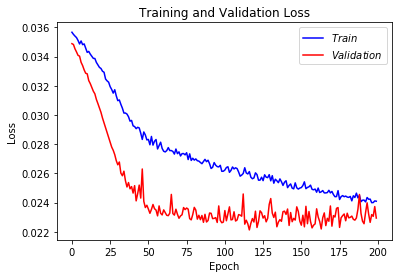

In [103]:
x = range(epoch)
y1 = loss_train_mean[x]
y2 = loss_test[x]

plt.plot(x, y1, color='b', label='$Train$')
plt.plot(x, y2, color='r', label='$Validation$')
plt.legend(loc="upper right")
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

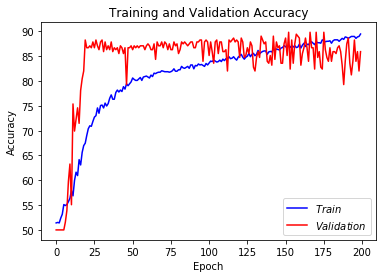

In [104]:
x = range(epoch)
y1 = accuracy_train[x]
y2 = accuracy_test[x]
plt.plot(x, y1, color='b', label='$Train$')
plt.plot(x, y2, color='r', label='$Validation$')
plt.legend(loc="lower right")
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [106]:
import seaborn as sns

In [113]:
sns.set(color_codes=True)
tips = sns.load_dataset(accuracy_train)
sns.lmplot(x = 'Epoch', y = 'Accuracy', data = tips)

InvalidURL: URL can't contain control characters. '/mwaskom/seaborn-data/master/[51.41187926 51.50925024 51.41187926 52.38558909 53.16455696 55.11197663\n 54.91723466 55.11197663 55.69620253 56.37779942 57.93573515 56.86465433\n 59.9805258  61.63583252 60.95423564 64.16747809 63.09639727 65.62804284\n 66.99123661 67.47809153 69.03602726 70.39922103 70.98344693 70.88607595\n 71.85978578 72.73612463 73.02823759 74.58617332 73.5150925  75.07302824\n 75.17039922 74.58617332 75.55988315 74.97565725 75.46251217 76.53359299\n 77.21518987 76.33885102 76.33885102 77.70204479 78.18889971 77.79941577\n 78.18889971 77.89678676 78.87049659 78.38364167 79.45472249 79.06523856\n 79.45472249 79.84420643 80.62317429 80.33106134 80.13631938 80.13631938\n 80.42843233 80.72054528 80.13631938 80.81791626 80.91528724 81.01265823\n 80.81791626 80.62317429 81.20740019 80.91528724 81.59688413 81.49951315\n 81.69425511 81.7916261  81.7916261  82.08373905 81.98636806 81.88899708\n 81.88899708 81.88899708 81.7916261  81.88899708 82.08373905 82.47322298\n 81.98636806 81.98636806 82.27848101 82.27848101 82.9600779  82.66796495\n 82.57059396 82.76533593 82.9600779  82.57059396 83.25219085 83.25219085\n 82.47322298 83.15481986 83.05744888 83.44693281 83.25219085 83.34956183\n 83.15481986 82.9600779  83.5443038  83.25219085 83.64167478 84.03115871\n 83.93378773 84.22590068 84.03115871 83.83641675 83.93378773 84.22590068\n 83.93378773 84.42064265 84.1285297  84.51801363 84.51801363 84.90749757\n 84.51801363 84.61538462 84.90749757 84.51801363 84.22590068 84.81012658\n 85.10223953 85.39435248 84.81012658 84.42064265 84.81012658 85.00486855\n 85.58909445 84.90749757 85.39435248 85.58909445 85.10223953 85.39435248\n 86.17332035 85.49172347 85.78383642 85.97857838 86.07594937 86.07594937\n 85.39435248 85.8812074  85.97857838 85.8812074  86.4654333  86.17332035\n 86.4654333  86.36806232 86.27069133 86.66017527 86.75754625 87.14703019\n 86.95228822 86.66017527 87.24440117 86.75754625 87.14703019 86.85491723\n 87.14703019 86.75754625 86.85491723 87.43914314 86.66017527 87.24440117\n 87.6338851  86.95228822 87.43914314 87.34177215 87.73125609 87.92599805\n 87.6338851  87.34177215 87.92599805 87.73125609 87.73125609 87.6338851\n 88.31548199 88.12074002 87.92599805 88.02336904 88.02336904 88.12074002\n 87.6338851  88.12074002 88.31548199 88.31548199 88.31548199 88.02336904\n 88.31548199 88.60759494 88.41285297 88.89970789 88.8023369  88.60759494\n 88.8023369  88.99707887 88.99707887 88.99707887 88.60759494 88.89970789\n 88.99707887 89.48393379].csv' (found at least ' ')